In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns

# 1. Data Loading
print("1. Data Loading")
data = pd.read_csv('/mnt/c/Users/muham/Documents/Documents/Tugas Kuliah/Tugas Kuliah Semester 6/Deep-Learning/Week 8 (UTS)/RegresiUTSTelkom.csv')

# Display info about the dataset
print("\nDataset Information:")
print(f"Shape: {data.shape}")
print(f"Columns: {data.columns.tolist()[:5]}... (total: {len(data.columns)})")
print(data.head())

2025-05-02 23:51:21.424368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746204681.450164  254172 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746204681.458912  254172 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-02 23:51:21.494945: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1. Data Loading

Dataset Information:
Shape: (515344, 91)
Columns: ['2001', '49.94357', '21.47114', '73.0775', '8.74861']... (total: 91)
   2001  49.94357  21.47114   73.0775   8.74861  -17.40628  -13.09905  \
0  2001  48.73215  18.42930  70.32679  12.94636  -10.32437  -24.83777   
1  2001  50.95714  31.85602  55.81851  13.41693   -6.57898  -18.54940   
2  2001  48.24750  -1.89837  36.29772   2.58776    0.97170  -26.21683   
3  2001  50.97020  42.20998  67.09964   8.46791  -15.85279  -16.81409   
4  2001  50.54767   0.31568  92.35066  22.38696  -25.51870  -19.04928   

   -25.01202  -12.23257   7.83089  ...   13.0162  -54.40548  58.99367  \
0    8.76630   -0.92019  18.76548  ...   5.66812  -19.68073  33.04964   
1   -3.27872   -2.35035  16.07017  ...   3.03800   26.05866 -50.92779   
2    5.05097  -10.34124   3.55005  ...  34.57337 -171.70734 -16.96705   
3  -12.48207   -9.37636  12.63699  ...   9.92661  -55.95724  64.92712   
4   20.67345   -5.19943   3.63566  ...   6.59753  -50.69577


Data Types:
float64    90
int64       1
Name: count, dtype: int64

Missing Values per Column:
2001         0
49.94357     0
21.47114     0
73.0775      0
8.74861      0
            ..
-23.08793    0
68.40795     0
-1.82223     0
-27.46348    0
2.26327      0
Length: 91, dtype: int64

Total Missing Values: 0



Target Variable Statistics:
Mean: 1998.3970765158806 | Min: 1922 | Max: 2011 | Std: 10.931045752973818


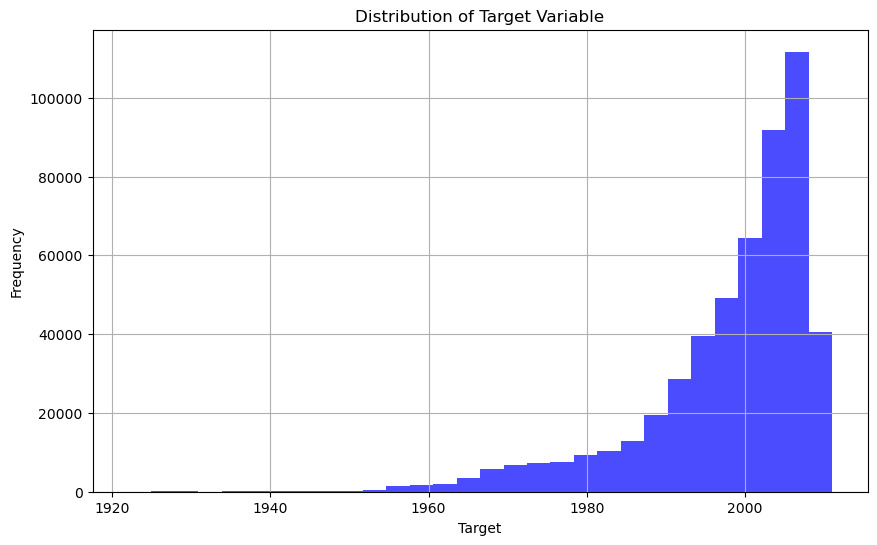

In [2]:
# Analyzing data types and missing values
print("\nData Types:")
print(data.dtypes.value_counts())
print("\nMissing Values per Column:")
print(data.isnull().sum())
print("\nTotal Missing Values:", data.isnull().sum().sum())

# Extract features and target
target_idx = 0       # Target the first column
y = data.iloc[:, target_idx].values
X = data.drop(data.columns[target_idx], axis=1)

# Basic statistics for target
print("\nTarget Variable Statistics:")
print(f"Mean: {np.mean(y)} | Min: {np.min(y)} | Max: {np.max(y)} | Std: {np.std(y)}")

# Visualize target distribution
plt.figure(figsize=(10, 6))
plt.hist(y, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [3]:
# 2. Feature Engineering and Preprocessing
print("\n2. Feature Engineering and Preprocessing")

# Check for outliers in the target variable using IQR
y_series = pd.Series(y)

Q1 = y_series.quantile(0.25)
Q3 = y_series.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"\nOutlier Thresholds for Target: Lower = {lower_bound}, Upper = {upper_bound}")
outliers = ((y < lower_bound) | (y > upper_bound)).sum()
print(f"Number of Outliers in Target: {outliers}")


2. Feature Engineering and Preprocessing

Outlier Thresholds for Target: Lower = 1976.0, Upper = 2024.0
Number of Outliers in Target: 29703


In [4]:
# Identify feature types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

print(f"\nFeature Types:")
print(f"Numeric Features: {len(numeric_features)}")
print(f"Categorical Features: {len(categorical_features)}")


Feature Types:
Numeric Features: 90
Categorical Features: 0



Top 10 Features by Correlation with Target:
49.94357     0.225373
-13.09905    0.187443
73.0775      0.139542
-10.7366     0.126348
73.04667     0.123975
-25.01202    0.110461
4.69525      0.102841
-18.60478    0.101324
-0.36994     0.101006
28.09139     0.099484
Name: 2001, dtype: float64


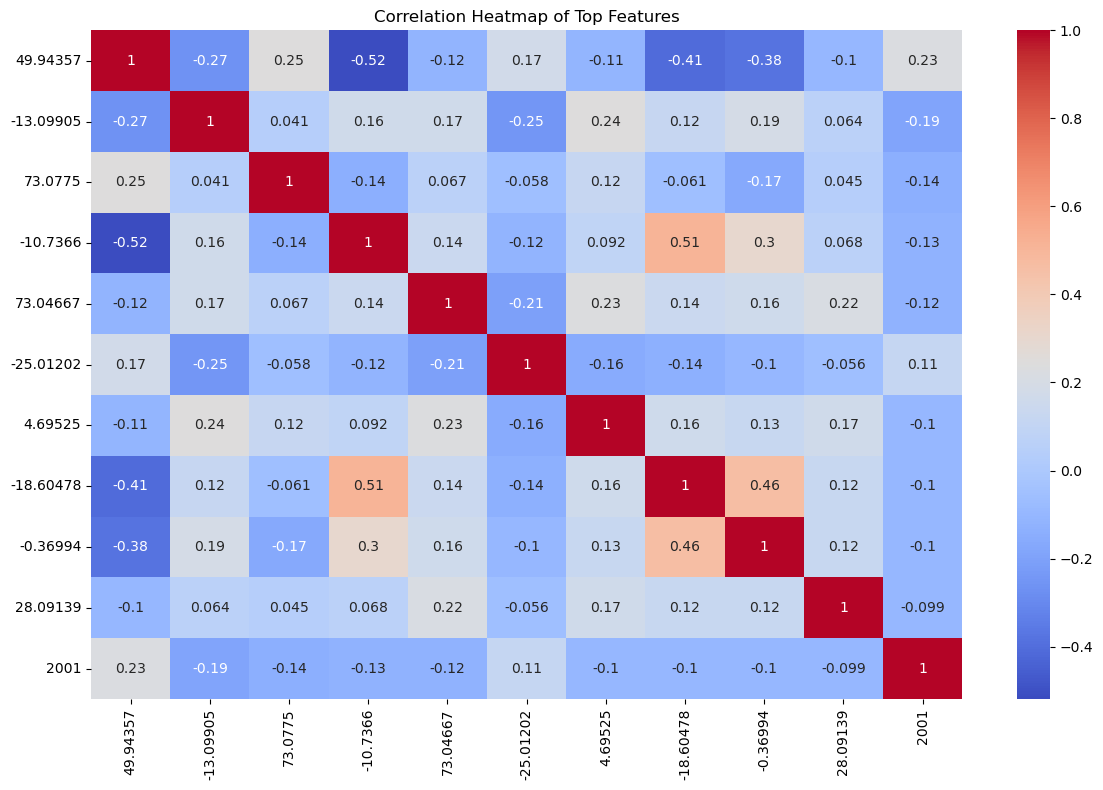

In [5]:
# Check correlation with target
correlation_matrix = data.corr()
target_correlations = correlation_matrix.iloc[0].drop(data.columns[0])
sorted_correlations = target_correlations.abs().sort_values(ascending=False)

print("\nTop 10 Features by Correlation with Target:")
print(sorted_correlations.head(10))

# Visualize top correlated features
plt.figure(figsize=(12, 8))
top_features = sorted_correlations.index[:10]
sns.heatmap(data[list(top_features) + [data.columns[0]]].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Top Features')
plt.tight_layout()
plt.show()


Dimensions after feature engineering: (515344, 50)

PCA Components Retained: 34
Dimensions after PCA: (515344, 34)


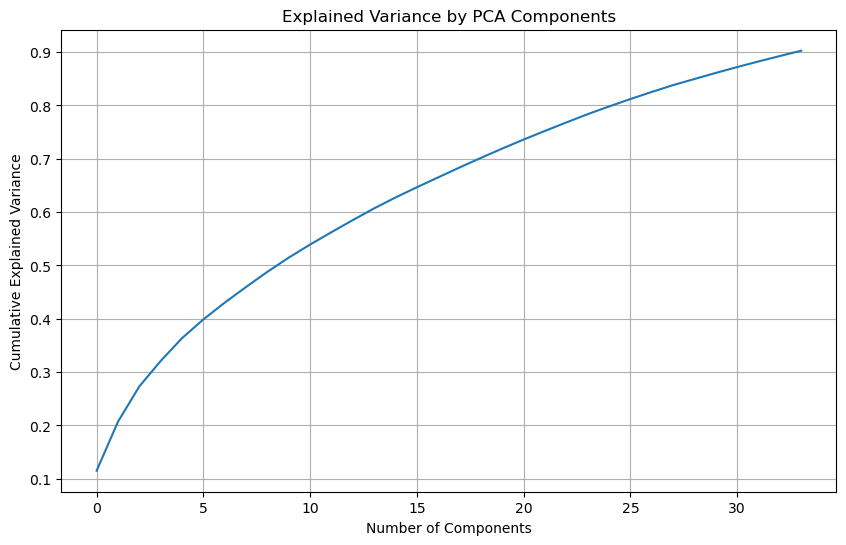

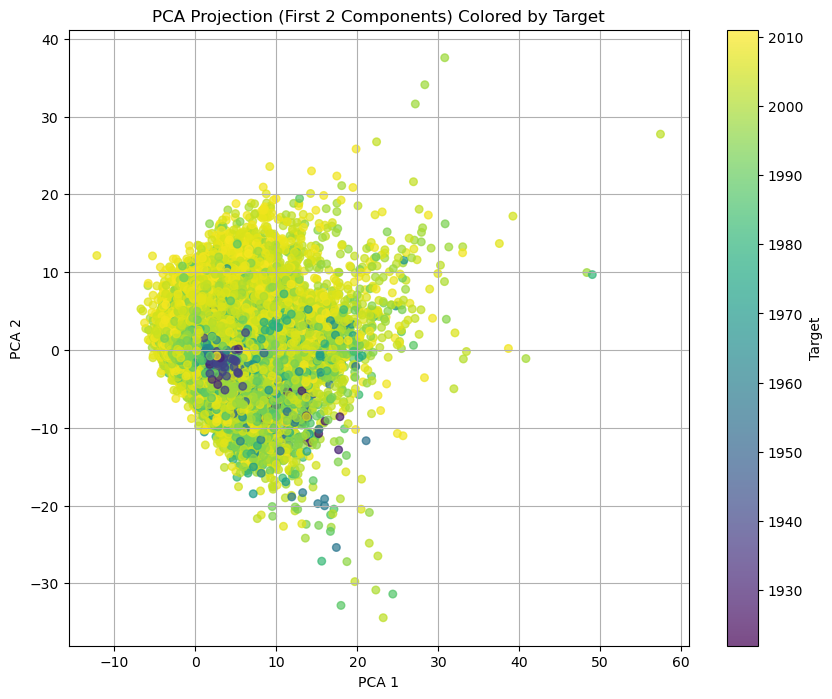

In [6]:
# Setting up preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ],
    remainder='passthrough'  # Include any columns not specified
)

# Feature selection pipeline (combined with preprocessing)
feature_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(f_regression, k=min(50, len(X.columns))))  # Select top 50 features or all if less
])

# Apply feature engineering pipeline
X_transformed = feature_pipeline.fit_transform(X, y)
print(f"\nDimensions after feature engineering: {X_transformed.shape}")

# Apply additional dimensionality reduction with PCA
pca = PCA(n_components=0.90)  # retain 90% variance
X_pca = pca.fit_transform(X_transformed)
print(f"\nPCA Components Retained: {pca.n_components_}")
print(f"Dimensions after PCA: {X_pca.shape}")

# Visualize explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Visualize first two PCA components
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=30, alpha=0.7)
plt.colorbar(label='Target')
plt.title('PCA Projection (First 2 Components) Colored by Target')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()


3. Creating Classification Labels
Bin edges based on percentiles: [1922. 1994. 2002. 2006. 2011.]

Class Distribution:
Class 0: 130318 instances (25.29%)
Class 1: 140946 instances (27.35%)
Class 2: 129475 instances (25.12%)
Class 3: 114599 instances (22.24%)


/tmp/ipykernel_254172/58493826.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_class_valid, palette='viridis')


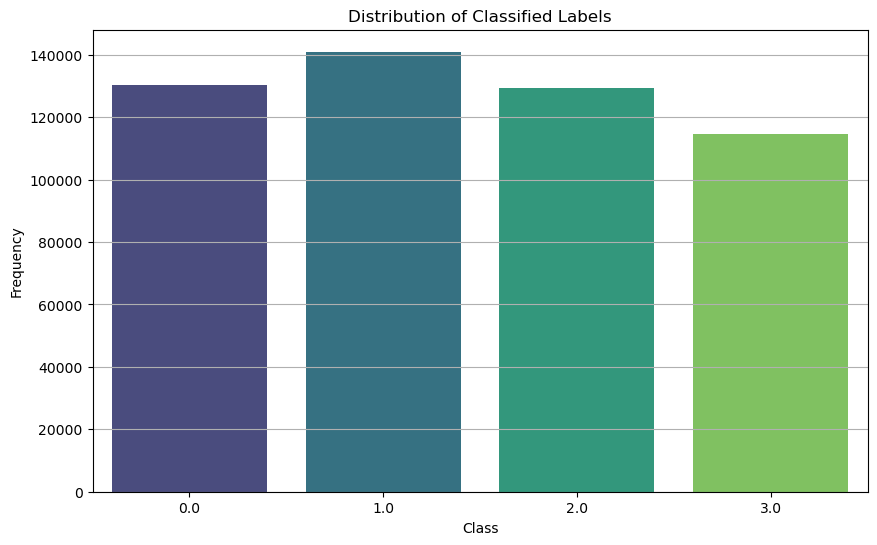

In [7]:
# 3. Classification label creation
print("\n3. Creating Classification Labels")

# Create classification bins based on percentiles
percentiles = [0, 25, 50, 75, 100]
bin_edges = np.percentile(y, percentiles)
print(f"Bin edges based on percentiles: {bin_edges}")

# Create classification labels
y_class = pd.cut(y, bins=bin_edges, labels=[0, 1, 2, 3])
y_class = y_class.astype(float)

# Filter valid rows (drop NaNs if any)
valid_idx = ~np.isnan(y_class)
X_pca_valid = X_pca[valid_idx]
y_valid = y[valid_idx]
y_class_valid = y_class[valid_idx]

# Display class distribution
class_counts = pd.Series(y_class_valid).value_counts().sort_index()
print("\nClass Distribution:")
for class_label, count in class_counts.items():
    print(f"Class {int(class_label)}: {count} instances ({count/len(y_class_valid)*100:.2f}%)")

# Visualize classified label distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y_class_valid, palette='viridis')
plt.title('Distribution of Classified Labels')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(True, axis='y')
plt.show()

# Encode classification labels
label_encoder = LabelEncoder()
y_class_encoded = label_encoder.fit_transform(y_class_valid)

# One-Hot Encoding
onehot_encoder = OneHotEncoder(sparse_output=False)
y_class_onehot = onehot_encoder.fit_transform(y_class_encoded.reshape(-1, 1))

In [8]:
# 4. Train-Test Split
print("\n4. Train-Test Split")

# Split data for regression
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_valid, y_valid, test_size=0.2, random_state=42, stratify=y_class_valid
)

# Split data for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_pca_valid, y_class_encoded, test_size=0.2, random_state=42, stratify=y_class_valid
)

# Create one-hot encoded targets for classification
y_train_class_onehot = onehot_encoder.transform(y_train_class.reshape(-1, 1))
y_test_class_onehot = onehot_encoder.transform(y_test_class.reshape(-1, 1))

# Final dataset shapes
print("\nFinal Dataset Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"X_train_class: {X_train_class.shape}, y_train_class: {y_train_class.shape}")
print(f"X_test_class: {X_test_class.shape}, y_test_class: {y_test_class.shape}")


4. Train-Test Split

Final Dataset Shapes:
X_train: (412270, 34), y_train: (412270,)
X_test: (103068, 34), y_test: (103068,)
X_train_class: (412270, 34), y_train_class: (412270,)
X_test_class: (103068, 34), y_test_class: (103068,)


In [9]:
# 5. Model Regression
print("\n5. Training Regression Model")

# Define callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Define regression model
regression_model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],)),
    LeakyReLU(negative_slope=0.2),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(128),
    LeakyReLU(negative_slope=0.2),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(64),
    LeakyReLU(negative_slope=0.2),
    BatchNormalization(),
    
    Dense(1)  # Output layer (regression)
])

# Compile regression model
regression_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse',
    metrics=['mae', 'mse']
)

# Model summary
regression_model.summary()


5. Training Regression Model


/home/ardi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746204726.297783  254172 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4057 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
W0000 00:00:1746204726.756669  254417 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/ardi/miniconda3/lib/python3.12/site-p

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         8,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,969 (203.00 KB)

 Trainable params: 51,073 (199.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [10]:
# Train regression model
history_reg = regression_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20


I0000 00:00:1746204730.252501  254406 service.cc:148] XLA service 0x7fd710011900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746204730.252540  254406 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-05-02 23:52:10.310581: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746204730.534623  254406 cuda_dnn.cc:529] Loaded cuDNN version 90800


  25/6442 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 3993728.5000 - mae: 1998.4039 - mse: 3993728.5000 

I0000 00:00:1746204733.128851  254406 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6442/6442 ━━━━━━━━━━━━━━━━━━━━ 55s 8ms/step - loss: 3963556.7500 - mae: 1990.8196 - mse: 3963556.7500 - val_loss: 3790201.5000 - val_mae: 1946.8196 - val_mse: 3790201.5000 - learning_rate: 1.0000e-04
Epoch 2/20
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - loss: 3696549.2500 - mae: 1922.4789 - mse: 3696549.2500 - val_loss: 3363304.2500 - val_mae: 1833.9081 - val_mse: 3363304.2500 - learning_rate: 1.0000e-04
Epoch 3/20
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - loss: 3226151.0000 - mae: 1795.7758 - mse: 3226151.0000 - val_loss: 2777152.0000 - val_mae: 1666.4524 - val_mse: 2777152.0000 - learning_rate: 1.0000e-04
Epoch 4/20
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step - loss: 2610785.5000 - mae: 1615.0830 - mse: 2610785.5000 - val_loss: 2093021.6250 - val_mae: 1446.6960 - val_mse: 2093021.6250 - learning_rate: 1.0000e-04
Epoch 5/20
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - loss: 1915227.5000 - mae: 1382.6697 - mse: 1915227.5000 - val_loss: 1385445.1250 - val_mae: 1177.0100 - val_ms

6. Evaluating Regression Model
3221/3221 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step
MSE: 89.8992
RMSE: 9.4815
MAE: 6.7751
R² Score: 0.2515


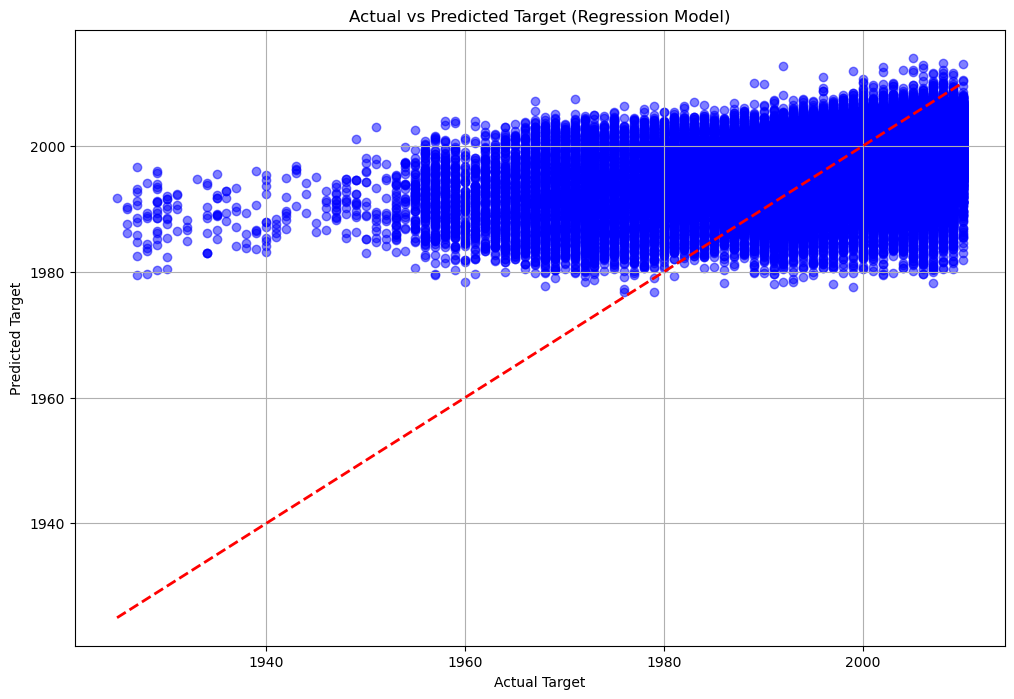

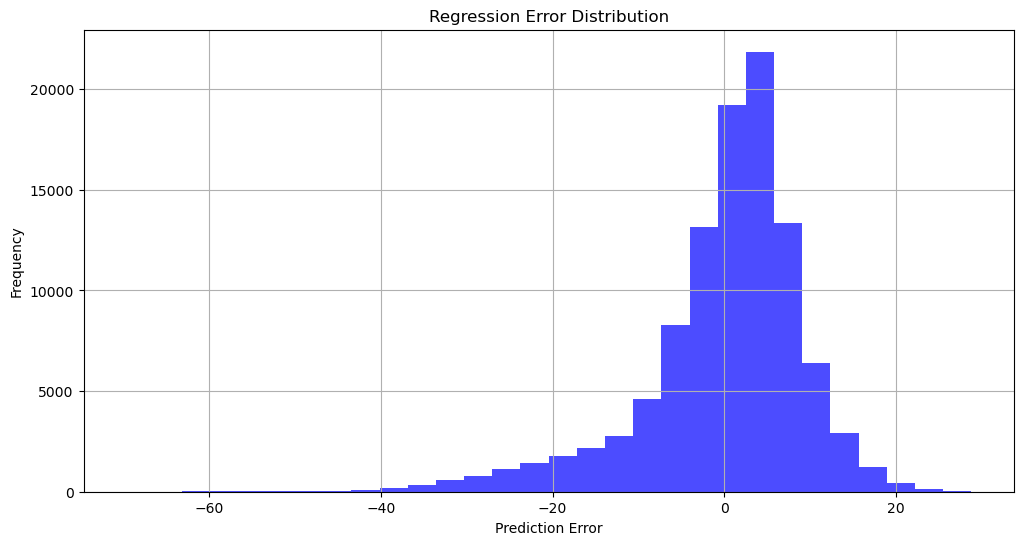

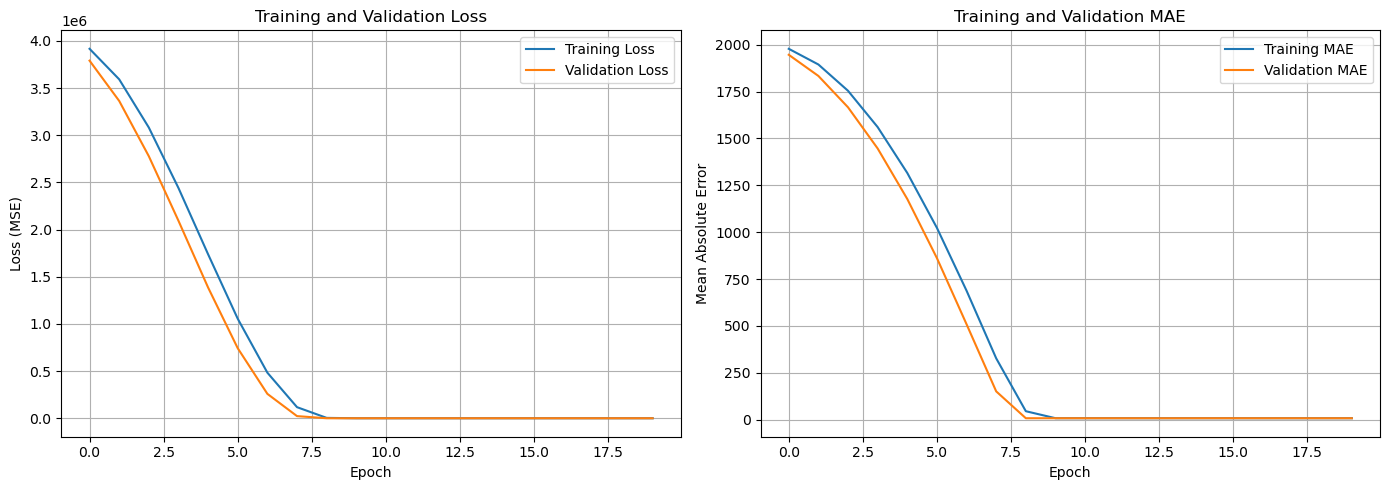

In [11]:
# 6. Evaluate Regression Model
print("6. Evaluating Regression Model")

# Make predictions
y_pred = regression_model.predict(X_test).flatten()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

# Print evaluation metrics
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Scatter plot of actual vs predicted values
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.5, c='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.title('Actual vs Predicted Target (Regression Model)')
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.grid(True)
plt.show()

# Regression error histogram
errors = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=30, color='blue', alpha=0.7)
plt.title('Regression Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_reg.history['loss'], label='Training Loss')
plt.plot(history_reg.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_reg.history['mae'], label='Training MAE')
plt.plot(history_reg.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# 7. Classification Model
print("7. Training Classification Model")

# Define classification model
classification_model = Sequential([
    Dense(256, input_shape=(X_train_class.shape[1],)),
    LeakyReLU(negative_slope=0.2),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(128),
    LeakyReLU(negative_slope=0.2),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(64),
    LeakyReLU(negative_slope=0.2),
    BatchNormalization(),
    
    Dense(4, activation='softmax')  # 4 classes output
])

# Compile classification model
classification_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
classification_model.summary()

7. Training Classification Model


/home/ardi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │         8,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,164 (203.77 KB)

 Trainable params: 51,268 (200.27 KB)

 Non-trainable params: 896 (3.50 KB)

In [13]:
# Train classification model
history_class = classification_model.fit(
    X_train_class, y_train_class,
    validation_data=(X_test_class, y_test_class),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 254s 37ms/step - accuracy: 0.3481 - loss: 1.3961 - val_accuracy: 0.3987 - val_loss: 1.2531 - learning_rate: 1.0000e-04
Epoch 2/20
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 283s 44ms/step - accuracy: 0.3907 - loss: 1.2674 - val_accuracy: 0.4098 - val_loss: 1.2405 - learning_rate: 1.0000e-04
Epoch 3/20
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 333s 52ms/step - accuracy: 0.3998 - loss: 1.2554 - val_accuracy: 0.4130 - val_loss: 1.2344 - learning_rate: 1.0000e-04
Epoch 4/20
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 277s 43ms/step - accuracy: 0.4045 - loss: 1.2458 - val_accuracy: 0.4149 - val_loss: 1.2310 - learning_rate: 1.0000e-04
Epoch 5/20
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 310s 48ms/step - accuracy: 0.4075 - loss: 1.2441 - val_accuracy: 0.4162 - val_loss: 1.2280 - learning_rate: 1.0000e-04
Epoch 6/20
6442/6442 ━━━━━━━━━━━━━━━━━━━━ 314s 49ms/step - accuracy: 0.4114 - loss: 1.2395 - val_accuracy: 0.4189 - val_loss: 1.2252 - learning_rate: 1.0000e-04
Epoch 7/20
6442/6442 ━━━━━━━━━━━━━

8. Evaluating Classification Model
3221/3221 ━━━━━━━━━━━━━━━━━━━━ 48s 15ms/step
Accuracy: 0.4244
Precision: 0.4128
Recall: 0.4244
F1-Score: 0.4129

Per-Class Metrics:
Class 0: Precision=0.5022, Recall=0.6990, F1=0.5845
Class 1: Precision=0.3758, Recall=0.3510, F1=0.3630
Class 2: Precision=0.3583, Recall=0.2992, F1=0.3261
Class 3: Precision=0.4182, Recall=0.3436, F1=0.3773


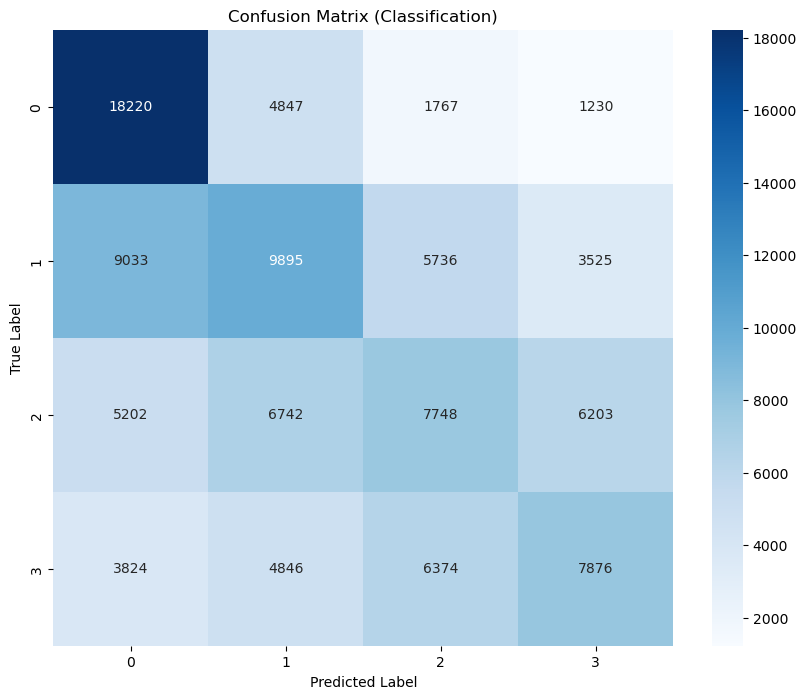

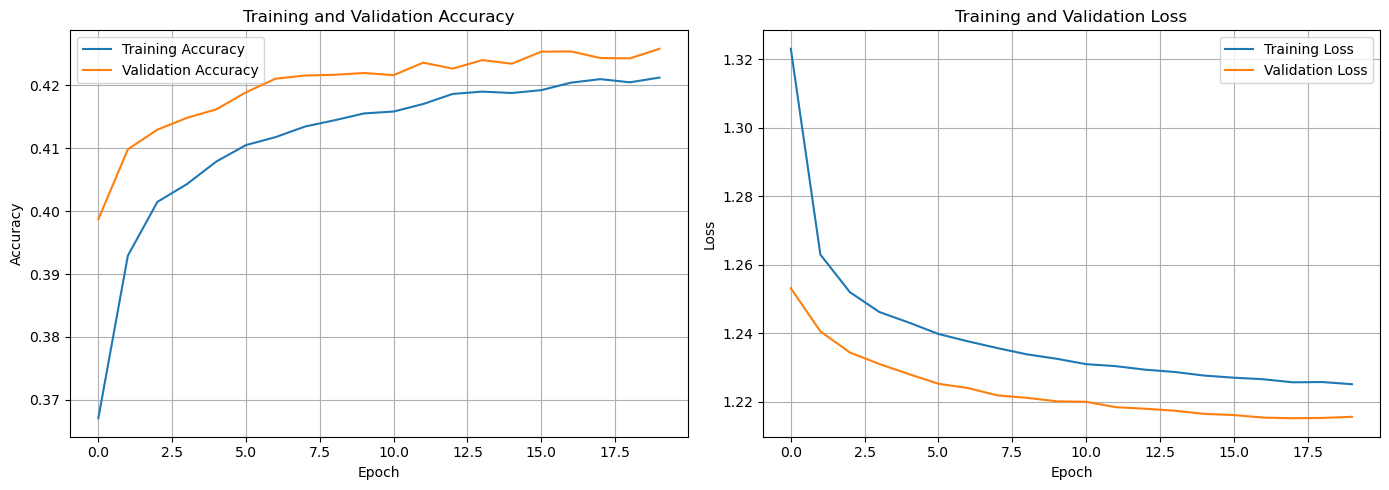


AUC-ROC Curve per Class


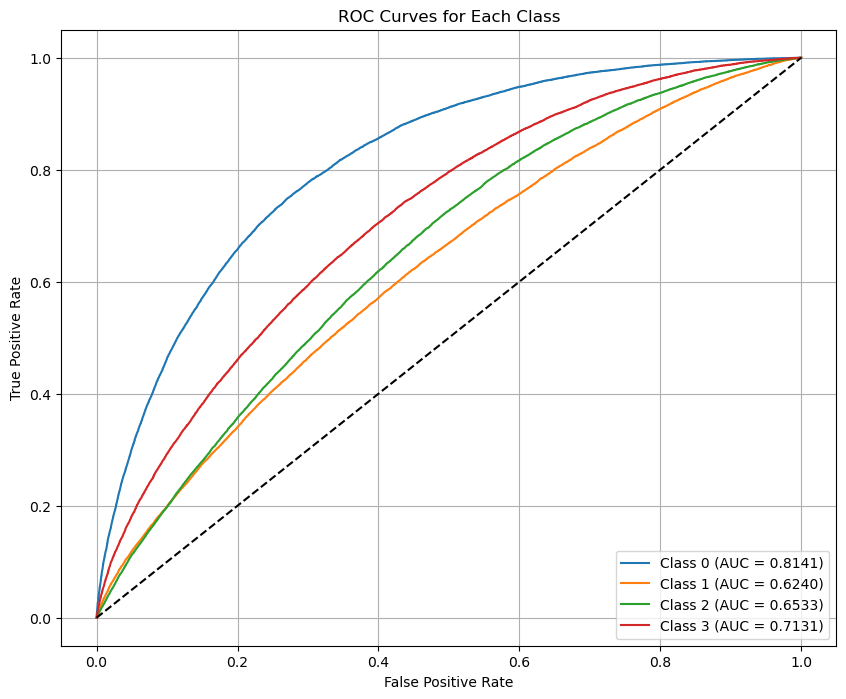

In [14]:
# 8. Evaluate Classification Model
print("8. Evaluating Classification Model")

# Make predictions
y_pred_probs = classification_model.predict(X_test_class)
y_pred_class = np.argmax(y_pred_probs, axis=1)

# Calculate metrics
acc = accuracy_score(y_test_class, y_pred_class)
prec = precision_score(y_test_class, y_pred_class, average='weighted')
rec = recall_score(y_test_class, y_pred_class, average='weighted')
f1 = f1_score(y_test_class, y_pred_class, average='weighted')

# Print evaluation metrics
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")

# Per-class metrics
print("\nPer-Class Metrics:")
for i in range(4):
    class_precision = precision_score(y_test_class, y_pred_class, labels=[i], average='micro')
    class_recall = recall_score(y_test_class, y_pred_class, labels=[i], average='micro')
    class_f1 = f1_score(y_test_class, y_pred_class, labels=[i], average='micro')
    print(f"Class {i}: Precision={class_precision:.4f}, Recall={class_recall:.4f}, F1={class_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=True)
plt.title('Confusion Matrix (Classification)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Training history plot
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_class.history['accuracy'], label='Training Accuracy')
plt.plot(history_class.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_class.history['loss'], label='Training Loss')
plt.plot(history_class.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# AUC-ROC Curve per Class
print("\nAUC-ROC Curve per Class")
y_onehot = tf.keras.utils.to_categorical(y_test_class, num_classes=4)

fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()